In [5]:
import requests
import pandas as pd
from datetime import datetime

def fetch_yahoo_news_api(ticker, count=20):
    url = (
        f"https://query1.finance.yahoo.com/v1/finance/search?"
        f"q={ticker}&newsCount={count}&quotesCount=0"
    )
    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    r = requests.get(url, headers=headers).json()

    if "news" not in r:
        return pd.DataFrame()  # no news found

    rows = []
    for item in r["news"]:
        try:
            title = item.get("title")
            link = item.get("link")
            publisher = item.get("publisher")
            ts = item.get("providerPublishTime")
            dt = datetime.utcfromtimestamp(ts)

            rows.append({
                "ticker": ticker,
                "title": title,
                "publisher": publisher,
                "datetime": dt,
                "url": link,
            })
        except:
            continue

    return pd.DataFrame(rows)


In [7]:
df_news = fetch_yahoo_news_api("AAPL", 20)
print(df_news.head(10))


  ticker                                              title  \
0   AAPL  Apple’s AI Troubles Are Fading. Just Look at t...   
1   AAPL           Review & Preview: Bitcoin Stops Bleeding   
2   AAPL  Apple's 6 straight records, bitcoin recovery: ...   
3   AAPL  S&P 500 Gains and Losses Today: Boeing Climbs ...   
4   AAPL  Apple (AAPL): Examining Valuation After Record...   
5   AAPL  Nasdaq Hits 3-Week High Amid Tech Boost; Boein...   
6   AAPL                  Why Intel Stock Soared 8.7% Today   
7   AAPL  Top Research Reports for Apple, Tesla & Micron...   
8   AAPL  Stocks post modest gains, Apple closes at a ne...   
9   AAPL  These Stocks Moved the Most Today: Apple, Boei...   

             publisher            datetime  \
0          Barrons.com 2025-12-03 00:51:00   
1          Barrons.com 2025-12-03 00:46:00   
2  Yahoo Finance Video 2025-12-02 23:00:04   
3         Investopedia 2025-12-02 22:17:52   
4      Simply Wall St. 2025-12-02 22:13:48   
5         MT Newswires 2025-12

In [8]:
df_news = fetch_yahoo_news_api("AAPL")
df_news["date"] = df_news["datetime"].dt.date
news_by_day = df_news.groupby("date")["title"].apply(list)


In [9]:
news_by_day

date
2025-12-02    [Apple's 6 straight records, bitcoin recovery:...
2025-12-03    [Apple’s AI Troubles Are Fading. Just Look at ...
Name: title, dtype: object

date
2025-12-02    8
2025-12-03    2
Name: count, dtype: int64


<Axes: xlabel='date'>

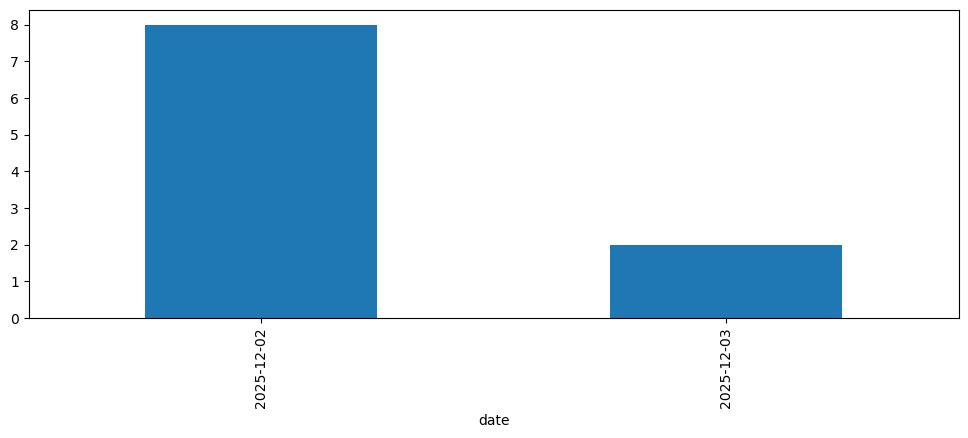

In [10]:
news_counts = df_news['date'].value_counts().sort_index()
print(news_counts)
news_counts.plot(kind='bar', figsize=(12,4))


In [11]:
df_news[df_news['url'].isna()]


,ticker,title,publisher,datetime,url,date


In [12]:
df_news['publisher'].value_counts()


publisher
Barrons.com            3
Yahoo Finance Video    2
Investopedia           1
Simply Wall St.        1
MT Newswires           1
Motley Fool            1
Zacks                  1
Name: count, dtype: int64

In [ ]:
import numpy as np

def embed_day_articles(titles, ticker):
    vectors = []
    for title in titles:
        v = generate_embedding(title, ticker)
        if v is not None:
            vectors.append(v)
    if len(vectors) == 0:
        return np.zeros(8)
    return np.mean(vectors, axis=0)     # aggregate daily sentiment


In [25]:
from gnews import GNews
import pandas as pd
from datetime import datetime

def fetch_gnews(ticker, start_date, end_date):
    google = GNews(
        language='en',
        country='US',
        max_results=100  # IMPORTANT: must be <= 100 for date filtering to work
    )

    # Set date filter
    google.start_date = pd.to_datetime(start_date).to_pydatetime()
    google.end_date = pd.to_datetime(end_date).to_pydatetime()

    # FIX: remove spaces from query
    query = f"{ticker} stock".replace(" ", "+")

    articles = google.get_news(query)
    rows = []

    for a in articles:
        try:
            dt = pd.to_datetime(a["published date"])
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "title": a["title"],
            "publisher": a["publisher"]["title"] if "publisher" in a else "",
            "datetime": dt,
            "url": a["url"]
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("datetime", ascending=False).reset_index(drop=True)
    return df


In [26]:
df_gnews = fetch_gnews("AAPL", "2024-11-01", "2024-12-01")
print(df_gnews.head(10))
print(len(df_gnews))


  ticker                                              title  \
0   AAPL  4 Reasons to Buy Apple Stock Like There's No T...   
1   AAPL  Apple (APPL) Stock Eyes $1T in Gains, Analyst ...   
2   AAPL  Apple Stock: A Golden Opportunity at $234.93 –...   
3   AAPL  How Apple Maintains Its Market Edge (NASDAQ:AA...   
4   AAPL  Here is Why Warren Buffett Sold AAPL Stock - Y...   
5   AAPL  Is Magnificent 7 Still a Good Bet for 2025? - ...   
6   AAPL  Apple Stock In 2025: A Prediction On Where It'...   
7   AAPL  Apple Stock Analysis: AAPL Proposes $100M Indo...   
8   AAPL  Here’s When the Big iPhone Supercycle Will Sta...   
9   AAPL  Billionaire Warren Buffett Sold 67% of Berkshi...   

           publisher            datetime  \
0    The Motley Fool 2024-12-01 08:00:00   
1         CryptoRank 2024-12-01 08:00:00   
2        TradingNEWS 2024-11-28 08:00:00   
3      Seeking Alpha 2024-11-27 08:00:00   
4      Yahoo Finance 2024-11-25 08:00:00   
5      Investing.com 2024-11-22 08:00:00  

In [40]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_reddit_search(ticker, days=7, max_posts=200):
    url = "https://www.reddit.com/search.json"
    headers = {"User-Agent": "Mozilla/5.0"}

    rows = []
    after_date = datetime.utcnow() - timedelta(days=days)
    after_timestamp = int(after_date.timestamp())

    params = {
        "q": f"{ticker}",
        "sort": "new",
        "limit": 100,   # Reddit max
        "t": "year"     # allow older results but we will filter manually
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
        print("Reddit API blocked:", response.status_code)
        return pd.DataFrame()

    data = response.json()

    for post in data["data"]["children"]:
        info = post["data"]

        ts = info.get("created_utc")
        if ts is None:
            continue

        dt = datetime.utcfromtimestamp(ts)

        # filter by days
        if dt < after_date:
            continue

        rows.append({
            "ticker": ticker,
            "subreddit": info.get("subreddit"),
            "title": info.get("title"),
            "text": info.get("selftext"),
            "datetime": dt,
            "url": "https://reddit.com" + info.get("permalink"),
            "score": info.get("score")
        })

        if len(rows) >= max_posts:
            break

    return pd.DataFrame(rows)


In [41]:
df_reddit = fetch_reddit_search("AAPL", days=7, max_posts=50)
print(df_reddit.head())
print(len(df_reddit))


  ticker        subreddit                        title  \
0   AAPL  ChineseUSStocks      我服了，AAPL 真是稳得让人抓狂又想笑 😂📈   
1   AAPL            fican        20M rate my portfolio   
2   AAPL        PiNetwork  Am I missing something here   
3   AAPL         chanceme   UPenn Wharton ED Chance Me   
4   AAPL         chanceme  UPenn Wharton ED: Chance me   

                                                text            datetime  \
0  苹果最近的走势总结一句话：“我今天不动哦，我真的不动哦…好吧偷偷涨一块…算了我又不动了。”\... 2025-12-03 03:21:04   
1  Started 1 month and a 1/2 ago. I have been try... 2025-12-03 02:03:27   
2  Why did I make a $31.4 deposit in Pionex.US \n... 2025-12-03 01:33:41   
3  I applied to Wharton ED and I was wondering wh... 2025-12-03 00:59:51   
4  I applied to Wharton ED and I was wondering wh... 2025-12-03 00:54:14   

                                                 url  score  
0  https://reddit.com/r/ChineseUSStocks/comments/...      1  
1  https://reddit.com/r/fican/comments/1pcrmj5/20...      3  
2  https

In [42]:
import feedparser
import pandas as pd
from datetime import datetime

def parse_rss(url, ticker):
    feed = feedparser.parse(url)
    rows = []

    for entry in feed.entries:
        title = entry.get("title", "")
        link = entry.get("link", "")
        published = entry.get("published", "")

        # Convert datetime safely
        try:
            dt = datetime(*entry.published_parsed[:6])
        except:
            dt = None

        rows.append({
            "ticker": ticker,
            "title": title,
            "publisher": url.split("//")[1].split("/")[0],  # domain name
            "datetime": dt,
            "url": link
        })

    return pd.DataFrame(rows)


In [43]:
RSS_FEEDS = [
    "https://www.cnbc.com/id/10001147/device/rss/rss.html",          # CNBC Markets
    "https://www.reuters.com/finance/markets/rss",                  # Reuters Markets
    "https://www.marketwatch.com/rss/topstories",                   # MarketWatch
    "https://www.nasdaq.com/feed/rssoutbound?category=Stock-Market",
    "https://feeds.a.dj.com/rss/RSSMarketsMain.xml",                # WSJ Markets
    "https://finance.yahoo.com/rss/topstories",                     # Yahoo RSS
    "https://www.investing.com/rss/news_25.rss",                    # Investing.com
]


In [44]:
def fetch_rss_news(ticker):
    dfs = []
    for feed in RSS_FEEDS:
        try:
            df = parse_rss(feed, ticker)
            dfs.append(df)
        except Exception as e:
            print("RSS Error:", feed, e)

    if len(dfs) == 0:
        return pd.DataFrame()

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = df_all.dropna(subset=["title"])
    df_all["datetime"] = pd.to_datetime(df_all["datetime"], errors="coerce")

    return df_all.reset_index(drop=True)


In [45]:
df_rss = fetch_rss_news("AAPL")
print(df_rss.head(10))
print("Total RSS articles:", len(df_rss))


KeyboardInterrupt: 

In [46]:
import pandas as pd
from datetime import timedelta

def unify_news_sources(df_yahoo, df_google, df_rss):
    # --- Combine all sources ---
    df = pd.concat([df_yahoo, df_google, df_rss], ignore_index=True)
    
    # --- Remove rows with missing title ---
    df = df.dropna(subset=["title"]).reset_index(drop=True)

    # --- Normalize title (remove punctuation / lowercase) ---
    df["title_norm"] = (
        df["title"]
        .str.lower()
        .str.replace(r"[^a-z0-9 ]", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    # --- FIRST PASS DEDUP: exact match on normalized title ---
    df = df.drop_duplicates(subset=["title_norm"], keep="first")

    # --- SECOND PASS DEDUP: group by similar timestamps ---
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

    df = df.sort_values("datetime").reset_index(drop=True)

    rows = []
    last_title = None
    last_time = None

    for _, row in df.iterrows():
        if last_title == row["title_norm"] and last_time is not None:
            if abs(row["datetime"] - last_time) < timedelta(hours=1):
                continue  # skip near-duplicate article

        rows.append(row)
        last_title = row["title_norm"]
        last_time = row["datetime"]

    df_clean = pd.DataFrame(rows).drop(columns=["title_norm"]).reset_index(drop=True)
    return df_clean


In [ ]:
df_yahoo = fetch_yahoo_news_api("AAPL")
df_google = fetch_gnews("AAPL", "2024-11-01", "2024-12-01")
df_rss   = None

df_all = unify_news_sources(df_yahoo, df_google, df_rss)

print(df_all.head(20))
print("Total unique articles:", len(df_all))


   ticker                                              title        publisher  \
0    AAPL  Apple (AAPL) Invests $1.5 Billion to Expand iP...           Nasdaq   
1    AAPL  If You'd Invested $1,000 in Apple Stock 10 Yea...    Yahoo Finance   
2    AAPL  Apple reports better-than-anticipated Q4 reven...    Yahoo Finance   
3    AAPL  If You'd Invested $1,000 in Apple Stock 10 Yea...  The Motley Fool   
4    AAPL  AAPL: Apple Posts 6% Sales Growth to $94.9 Bil...      TradingView   
5    AAPL  As Apple reports record Q3 sales, why’s the sh...          Fool UK   
6    AAPL  Globalstar stock rallies on expanded satellite...    Seeking Alpha   
7    AAPL  Warren Buffett's Berkshire Hathaway Sells Appl...     Investopedia   
8    AAPL  Apple Intelligence Products Could Make Up For ...    Yahoo Finance   
9    AAPL  Stock Market Today: Stocks Slip Ahead of Elect...        Kiplinger   
10   AAPL  Apple Stock Price Levels to Watch as Buffett's...     Investopedia   
11   AAPL  Warren Buffett’s 

In [ ]:
import numpy as np

def embed_all_articles(df):
    vectors = []
    for text in df["title"]:
        v = generate_embedding(text)
        vectors.append(v)
    df["embedding"] = vectors
    return df


In [ ]:
import faiss
import numpy as np

def build_faiss_index(df):
    # Convert to float32 matrix
    embeds = np.vstack(df["embedding"].values).astype("float32")

    index = faiss.IndexFlatL2(embeds.shape[1])   # 8 dims
    index.add(embeds)

    return index


In [ ]:
def make_daily_query_embedding(ticker, date):
    query_text = f"{ticker} relevant financial news for {date}"
    return np.array(generate_embedding(query_text), dtype="float32")


In [ ]:
def retrieve_top_k(df, index, query_vec, k=3):
    query_vec = query_vec.reshape(1, -1)
    D, I = index.search(query_vec, k)
    return df.iloc[I[0]]


In [ ]:
def aggregate_daily(df_daily):
    arr = np.vstack(df_daily["embedding"].values)
    return arr.mean(axis=0)


In [ ]:
def get_daily_news_embeddings(df, ticker, k=3):
    df["date"] = df["datetime"].dt.date
    index = build_faiss_index(df)

    daily_vectors = []

    for date in sorted(df["date"].unique()):
        query_vec = make_daily_query_embedding(ticker, date)
        top_df = retrieve_top_k(df, index, query_vec, k=k)

        agg_vec = aggregate_daily(top_df)
        daily_vectors.append((date, agg_vec))

    return daily_vectors


In [ ]:
import numpy as np

def aggregate_daily_attention_weighted(df_daily, distances):
    """
    df_daily: DataFrame of top-k articles for a day
    distances: Corresponding L2 distances from FAISS search
    """
    embeddings = np.vstack(df_daily['embedding'].values)
    
    # Convert FAISS distance to similarity score (closer = more relevant)
    # Small epsilon to avoid division by zero
    similarities = 1.0 / (distances + 1e-8)
    
    # Use the 'intensity' dimension (index 1 in your 8D vector) as content weight
    intensities = embeddings[:, 1]  # Your 2nd dimension: intensity
    
    # Combine relevance (FAISS similarity) and content intensity
    combined_weights = similarities * (1.0 + intensities)  # intensity amplifies
    
    # Normalize weights
    if combined_weights.sum() > 0:
        combined_weights = combined_weights / combined_weights.sum()
    else:
        combined_weights = np.ones(len(embeddings)) / len(embeddings)
    
    # Weighted average
    weighted_embedding = np.sum(embeddings * combined_weights[:, np.newaxis], axis=0)
    return weighted_embedding

In [ ]:
def aggregate_daily_dimension_wise(df_daily):
    """
    Smart pooling: different strategies per dimension
    """
    embeddings = np.vstack(df_daily['embedding'].values)
    
    # For polarity, relevance, credibility: USE MEAN (consensus)
    # For intensity, volatility, novelty: USE MAX (capture extremes)
    
    agg_vector = np.zeros(8)
    
    # Dimensions to average (0, 2, 7): polarity, relevance, credibility
    agg_vector[0] = embeddings[:, 0].mean()  # polarity
    agg_vector[2] = embeddings[:, 2].mean()  # relevance  
    agg_vector[7] = embeddings[:, 7].mean()  # credibility
    
    # Dimensions to max-pool (1, 5, 6): intensity, volatility, novelty
    agg_vector[1] = embeddings[:, 1].max()  # intensity
    agg_vector[5] = embeddings[:, 5].max()  # volatility
    agg_vector[6] = embeddings[:, 6].max()  # novelty
    
    # Mixed strategy for short/long term (4, 5): weighted by relevance
    relevance_weights = embeddings[:, 2]  # relevance dimension
    if relevance_weights.sum() > 0:
        relevance_weights = relevance_weights / relevance_weights.sum()
        agg_vector[3] = np.sum(embeddings[:, 3] * relevance_weights)  # short_term
        agg_vector[4] = np.sum(embeddings[:, 4] * relevance_weights)  # long_term
    else:
        agg_vector[3] = embeddings[:, 3].mean()
        agg_vector[4] = embeddings[:, 4].mean()
    
    return agg_vector